<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MOp-L6-CT-Foxp2"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/MOp/L6-CT-Foxp2/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

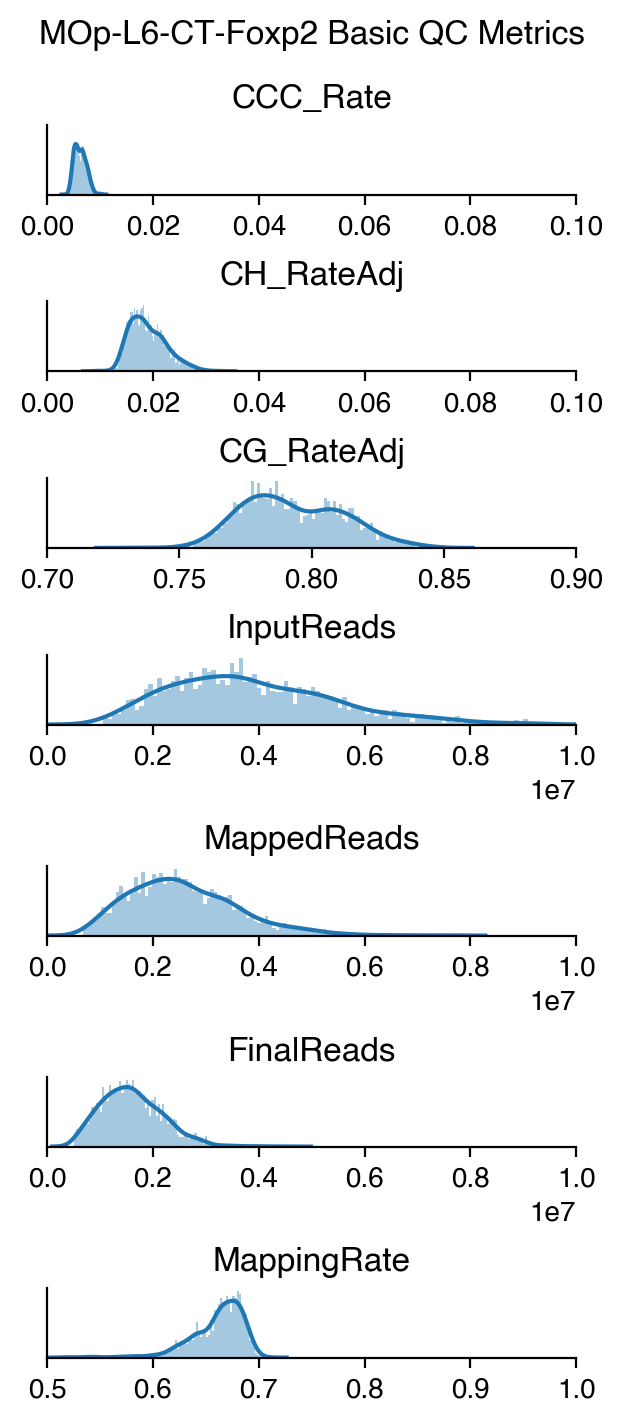

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

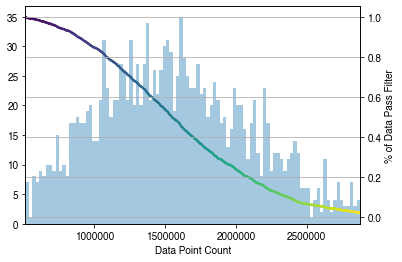

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1622/1622 (100.0%)
CG_RateAdj passed 1622/1622 (100.0%)
CH_RateAdj passed 1622/1622 (100.0%)
FinalReads passed 1622/1622 (100.0%)
MappingRate passed 1622/1622 (100.0%)
Overall passed 1622/1622 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 204
171207 243
171212 46
171213 243
180104 256
180409 33
180410 34
180605 291
180612 272


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 189 49.2%
ad002 204 53.1%
ad004 199 51.8%
ad006 211 54.9%
ad007 228 59.4%
ad008 189 49.2%
ad010 211 54.9%
ad012 191 49.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter,consensus_cluster_rescued_anno
index,,,,,,,,,,,,,,,,,,,,,
2C_M_1035,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00616,0.78792,0.78661,0.02696,0.02093,1863623.0,4176688,2856258.0,2C,...,G1,CEMBA180409-2C-4,0,6,0,13,180409,2,True,L6-CT-Foxp2
2C_M_104,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00493,0.76961,0.76847,0.01881,0.01395,1745864.0,4234286,2888276.0,2C,...,B2,CEMBA180409-2C-1,1,1,3,3,180409,2,True,L6-CT-Foxp2
2C_M_1108,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00494,0.78078,0.77969,0.01950,0.01463,1566939.0,3527530,2362752.0,2C,...,H1,CEMBA180409-2C-4,0,7,0,14,180409,2,True,L6-CT-Foxp2
2C_M_115,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00523,0.77785,0.77668,0.02060,0.01545,1804882.0,4259634,2874237.0,2C,...,B3,CEMBA180409-2C-2,2,1,5,3,180409,2,True,L6-CT-Foxp2
2C_M_1150,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00531,0.79241,0.79130,0.02351,0.01830,2044434.0,4672486,3204680.0,2C,...,H8,CEMBA180409-2C-4,7,7,14,14,180409,2,True,L6-CT-Foxp2
2C_M_119,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00551,0.78637,0.78519,0.02290,0.01749,1558524.0,3409058,2308856.0,2C,...,B4,CEMBA180409-2C-1,3,1,7,3,180409,2,True,L6-CT-Foxp2
2C_M_1234,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00541,0.78392,0.78274,0.02209,0.01677,1758869.0,3900020,2685068.0,2C,...,B10,CEMBA180410-2C-2,9,1,19,3,180410,2,True,L6-CT-Foxp2
2C_M_1242,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00535,0.77237,0.77115,0.02055,0.01528,1567245.0,3554446,2431848.0,2C,...,B11,CEMBA180410-2C-2,10,1,21,3,180410,2,True,L6-CT-Foxp2
2C_M_1312,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00631,0.80815,0.80693,0.03025,0.02409,1904696.0,4536144,3003661.0,2C,...,C11,CEMBA180410-2C-2,10,2,20,5,180410,2,True,L6-CT-Foxp2
